In [1]:
# Librerías utilizadas por el script
import os
import cv2
import zipfile
import csv
import pathlib
import shutil

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from copy import deepcopy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fasst.ai/t/plotting-metrics-after-learning/69937

import fastbook

fastbook.setup_book()
import fastai
import fastcore

print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *


@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


In [3]:
df = pd.read_csv('trainSet.csv')

In [4]:
def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("\\")[1]]
        return ((el['class'].values[0]))
    else:
        el = df.loc[df['image'] == str(fname).split("\\")[1]]
        return ((el['class'].values[0]))

In [5]:
# División en 60% train y 40% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.4, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(256, method='squish')],  # Redimensionado
).dataloaders("trainThumbnails/", bs=32)


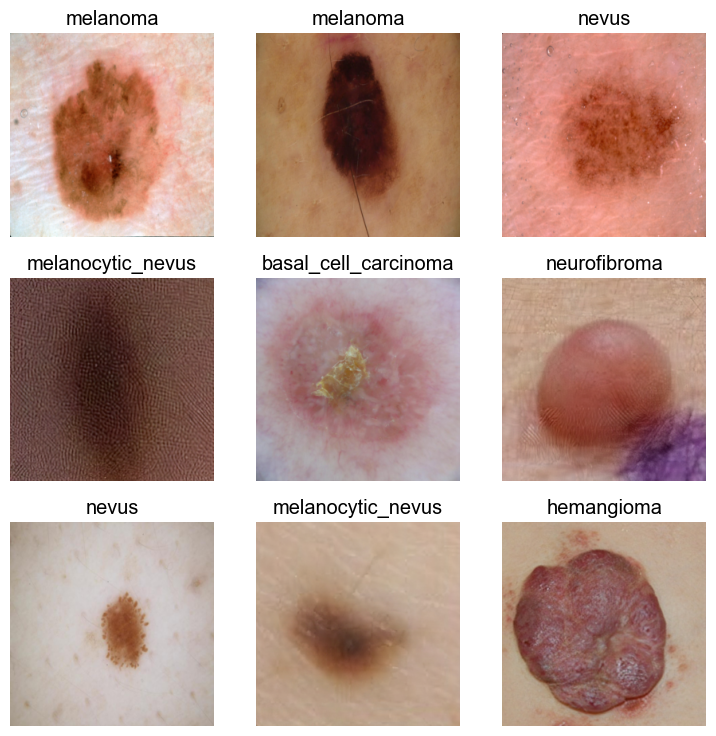

In [6]:
trainSet.show_batch()  # shows a batch of images

In [7]:
from fastai.vision.all import *
import timm

efnet_3 = timm.create_model('tf_efficientnet_lite3', pretrained=True)
efnet_3.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
   

In [8]:
efnet_3_learner = Learner(trainSet, efnet_3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
efnet_3_learner.summary()

EfficientNet (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 128 x 128 
Conv2dSame                                864        True      
Identity                                                       
ReLU6                                                          
Conv2d                                    288        True      
Identity                                                       
ReLU6                                                          
Identity                                                       
____________________________________________________________________________
                     32 x 24 x 128 x 128 
Conv2d                                    768        True      
Identity                                                       
Identity                                                       
____________________________________________________________________________
           

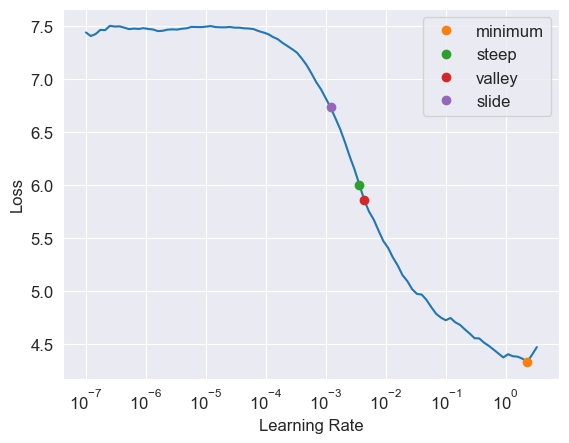

In [9]:
lrs = efnet_3_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [18]:
print("Valores propuestos: ",lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

Valores propuestos:  SuggestedLRs(minimum=0.2290867567062378, steep=0.00363078061491251, valley=0.004365158267319202, slide=0.0012022644514217973)

Valle (Smith Fit One cycle) 0.004365158267319202


In [19]:
efnet_3_learner.fine_tune(epochs=40, base_lr=lrs[2],cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5))

epoch,train_loss,valid_loss,accuracy,error_rate,time


KeyboardInterrupt: 